<a href="https://colab.research.google.com/github/plnu-biomechanics/kin6015/blob/main/notebooks/kin6015_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.pointloma.edu/sites/default/files/styles/basic_page/public/images/PLNU_Biomechanics_Lab_green_yellowSD_HiRes.png" width=400>

## **KIN 6015 Biomechanical Basis of Human Movement**
Instructor: Arnel Aguinaldo, PhD

**Lab 1 Data Processing**

In this lab, gait analysis data was collected with the marker-based and markerless motion capture systems and spatiotemporal metrics and inverse kinematics (IK) were estimated using Visual3D. The data were then exported as text (*.txt) files and uploaded to the class repository in the lab's [GitHub](https://github.com/plnu-biomechanics).

To further process the data for this lab, follow the steps in this **Colab notebook**, which contains instructions and sample code on how to wrangle and analyze the data.


### Create your own Colab Notebook

1. Go to **File -> New notebook in Drive** to open a new notebook in your Python environment:<br>
<img src="https://raw.githubusercontent.com/plnu-biomechanics/kin6015/main/notebooks/images/file_notebook.png" width=450>

2. Rename your Colab notebook using this naming format: **lastname_group_lab#.ipynb** (e.g., "aguinaldo_targaryen_lab1.ipynb")
3. Click on the **+ Code** option above to insert a new code cell: <br>
<img src="https://raw.githubusercontent.com/plnu-biomechanics/kin6015/main/notebooks/images/addcode.png" width=280>

4. The data you will parse and analyze for this lab will be copied from the lab's GitHub and temporarily stored in your Colab working directory, which can be accessed by clicking on the folder icon in the left menu:<br>
<img src="https://raw.githubusercontent.com/plnu-biomechanics/kin6015/main/notebooks/images/colab_folder.png" width=400>

5. Copy the following lines of code to import the packages needed for this analysis and to load the data files into your working directory. Be sure to update the `GROUP` variable with your group's name. **Note**: These files are "runtime" access only, meaning they are only temporarily stored in your working directory and show up when your notebook is in session. However, the following code cell allows you to clone the zipped files to the working directory each time it is executed.


In [ ]:
import urllib.request
import zipfile
import os

# --------------------------------------------------
# STUDENT INPUT (edit only this line; case-sensitive)
# --------------------------------------------------
GROUP = "targaryen"   # e.g., "targaryen", "stark", "lannister", "martel"

# --------------------------------------------------
# Configuration (do NOT edit below)
# These lines create a directory for this lab in your
# Colab working directory.
# --------------------------------------------------
zip_dir = "kin6015/lab1"
os.makedirs(zip_dir, exist_ok=True)

zip_filename = f"spring2026_lab1_{GROUP}.zip"

url = (
    "https://raw.githubusercontent.com/"
    "plnu-biomechanics/kin6015/main/"
    f"labs/{zip_filename}"
)

zip_path = os.path.join(zip_dir, zip_filename)

# --------------------------------------------------
# Download zip file
# --------------------------------------------------
urllib.request.urlretrieve(url, zip_path)

# --------------------------------------------------
# Extract contents from the zipped file
# --------------------------------------------------
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(zip_dir)

print("Extracted files in lab directory:")
print(os.listdir(zip_dir))


## 🔄 Data Parsing

You can add your own code below to parse the data needed for this lab by either using GenAI (e.g., Gemini, ChatGPT) or simply copying the prepared code below.

### ✋ GenAI prompt:
Parse the data from the text files so that they are two unique data frames, one for the timeseries data and another for the discrete metrics. The timeseries data (101 frames) are in the `Right Knee Angles` and `Right Ankle Dorsiflexion` columns and the discrete metrics are in the remaining columns in row 6 (index 5). Be sure to organize them by marker-based (MB) and markerless (ML) conditions, which are denoted in the filename as metadata. Rename any columns with the `Right Ankle Angles` with `Right Ankle Dorsiflexion`.

### ✅ Pre-compiled code:


In [28]:
import pandas as pd
import os
import re # Import the regular expression module

def parse_txt_file(filepath):
  """Reads a text file, extracts variable names and time-series data, identifies the condition,
  and returns a pandas DataFrame.

  Args:
    filepath (str): The full path to the text file.

  Returns:
    pd.DataFrame: A DataFrame containing the extracted data, condition, and filename.
  """
  with open(filepath, 'r') as file:
    lines = file.readlines()

  # Check if file has enough lines for the expected structure
  if len(lines) < 6: # Need at least 6 lines (5 header, 1 data)
      raise ValueError(f"File {os.path.basename(filepath)} has too few lines to parse correctly.")

  # Extract variable names from the 2nd line (index 1), using tab as delimiter
  variable_names = lines[1].strip().split('\t')

  # Read time-series data starting from the 6th line (index 5), using tab as delimiter
  data_lines = [line.strip().split('\t') for line in lines[5:] if line.strip()]

  # Ensure data_lines is not empty before checking lengths
  if not data_lines:
      raise ValueError(f"No data found in file {os.path.basename(filepath)} after header.")

  # Dynamically add 'Frame' if data rows have one more column than variable names
  if len(data_lines[0]) == len(variable_names) + 1:
      variable_names.insert(0, 'Frame')

  # Ensure variable names and data lines match in length AFTER potential adjustment
  if len(variable_names) != len(data_lines[0]):
      raise ValueError(f"Column name count ({len(variable_names)}) does not match data column count ({len(data_lines[0])}) in file {os.path.basename(filepath)}.")

  # Create DataFrame
  df = pd.DataFrame(data_lines, columns=variable_names)

  # Rename 'Right Ankle Angles' to 'Right Ankle Dorsiflexion' if it exists
  if 'Right Ankle Angles' in df.columns:
    df = df.rename(columns={'Right Ankle Angles': 'Right Ankle Dorsiflexion'})

  # Remove '_MEAN' or '_Mean' suffixes from column names
  new_columns = []
  for col in df.columns:
      new_col = re.sub(r'_MEAN$|_Mean$', '', col)
      new_columns.append(new_col)
  df.columns = new_columns

  # Convert numeric columns to appropriate data types
  for col in df.columns:
    try:
      df[col] = pd.to_numeric(df[col])
    except ValueError:
      pass # Keep as string if not numeric

  # Determine 'condition' from filename
  filename = os.path.basename(filepath)
  if 'MB' in filename.upper(): # Changed to upper() for accurate matching of 'MB'
    condition = 'marker-based'
  elif 'ML' in filename.upper(): # Changed to upper() for accurate matching of 'ML'
    condition = 'markerless'
  else:
    condition = 'unknown'

  # Add 'condition' column
  df['condition'] = condition

  # Add 'filename' column
  df['filename'] = filename

  return df

print("Updated function 'parse_txt_file' to handle tab-delimited data, correct line indexing, dynamic 'Frame' column, case-sensitive condition check, import 're' module, rename 'Right Ankle Angles' column, and remove '_MEAN'/'_Mean' suffixes.")


# 1. Get the list of .txt files from the working directory
zip_dir = "kin6015/lab1"
all_files = os.listdir(zip_dir)
txt_files = [f for f in all_files if f.endswith('.txt')]

# 2. Initialize an empty list to store DataFrames
all_dataframes = []

# 3. Iterate through each .txt file and apply the parse_txt_file function
for filename in txt_files:
    filepath = os.path.join(zip_dir, filename)
    try:
        df = parse_txt_file(filepath)
        all_dataframes.append(df)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

# 4. Concatenate all DataFrames into a single combined_intermediate_df
if all_dataframes:
    combined_intermediate_df = pd.concat(all_dataframes, ignore_index=True)
    print("Combined_intermediate_df created successfully.")
else:
    combined_intermediate_df = pd.DataFrame()
    print("No dataframes to concatenate, combined_intermediate_df is empty.")

# 5. Create timeseries_df
timeseries_df = combined_intermediate_df[['Frame', 'Right Knee Angles', 'Right Ankle Dorsiflexion', 'condition', 'filename']]

# 6. Create discretes_df
discretes_df = combined_intermediate_df[combined_intermediate_df['Frame'] == 1][['Speed', 'Stride_Length', 'Right_Stance_Time', 'Ankle Plantarflexion at IC', 'Peak Right Knee Flexion', 'condition', 'filename']]

# 7. Display the head of timeseries_df
print("\nHead of timeseries_df:")
print(timeseries_df.head())

# 8. Display the head of discretes_df
print("\nHead of discretes_df:")
print(discretes_df.head())

Updated function 'parse_txt_file' to handle tab-delimited data, correct line indexing, dynamic 'Frame' column, case-sensitive condition check, import 're' module, rename 'Right Ankle Angles' column, and remove '_MEAN'/'_Mean' suffixes.
Combined_intermediate_df created successfully.

Head of timeseries_df:
   Frame  Right Knee Angles  Right Ankle Dorsiflexion     condition  \
0      1            3.54527                  -4.28667  marker-based   
1      2            5.48596                  -4.88219  marker-based   
2      3            6.19649                  -6.12455  marker-based   
3      4            6.24373                  -7.95542  marker-based   
4      5            6.29172                  -9.57410  marker-based   

              filename  
0  Targaryen_MB_05.txt  
1  Targaryen_MB_05.txt  
2  Targaryen_MB_05.txt  
3  Targaryen_MB_05.txt  
4  Targaryen_MB_05.txt  

Head of discretes_df:
       Speed  Stride_Length  Right_Stance_Time  Ankle Plantarflexion at IC  \
0    1.39355   

## Statistical Parametric Mapping (SPM)

Statistical parametric mapping (SPM) uses Random Field Theory to make statistical inferences about normalized sets of biomechanical variables across time (1D). It can be used to compare kinematic, kinetic, or EMG time-series curves using traditional NHST statistical tests such as a t-test, ANOVA, and linear regression. In this course, we will be using the package, `spm1d`, in [Python](https://spm1d.org/index.html) to perform some basic SPM analyses.

Before we perform the SPM analyses, we must prepare the time-series data so that they can be properly structured for SPM. The process of preparing and organizing raw data into usable data is known as **data wrangling**. For SPM, the time-series data must be structured so that each variable for each condition (i.e., conventional, sumo) is its own data file, where the data is organized in a *JxQ* array:

* J = number of trials or subjects
* Q = number of frames or time points (i.e., 100)

The following code wrangles the time-series data in these arrays and exports them into individual text files for subsequent SPM analysis. This will allow the `spm1d` package to average the data at each frame across all trials in a process known as **ensemble averaging** where the solid thick lines represent the mean and the semi-transparent bands represent the +/- 1 standard deviation:

<img src="https://raw.githubusercontent.com/plnu-biomechanics/kin6015/main/notebooks/images/SPM_plot_sample.png">

This two-line cell installs the `spm1d` library in runtime environment and confirms installation.

In [ ]:
!pip install spm1d
print("spm1d library installed.")

# Data Wrangling

Now the data from the `timeseries_df` data frame must be extracted and formatted so that they can be properly analyzed using SPM. This is a part of the data wrangling process and is a common and important part of the data parsing process.

✋ GenAI prompt:
Generate code that wrangles the time-series data into a SPM friendly format for the time-series data in this lab (e.g., Right Knee Angles, Right Ankle Dorsiflexion). Each data array should be in the shape of j x q where j = 5 (conditions) and q = 101 (frames). There would be a total of 4 separate data arrays:

*   knee_flexion_mb
*   knee_flexion_ml
*   ankle_dorsiflexion_mb
*   ankle_dorsiflexion_ml


✅ Pre-compiled code:

In [ ]:
import numpy as np

# ================
# DATA WRANGLING
# =================

# This code chunk wrangles time-series data into respective arrays for SPM analysis

# Recreate timeseries_df with .copy() to avoid SettingWithCopyWarning
timeseries_df = combined_intermediate_df[['Frame', 'Right Knee Angles', 'Right Ankle Dorsiflexion', 'condition', 'filename']].copy()

# Add 'trial_id' column by cleaning the 'filename'
timeseries_df['trial_id'] = timeseries_df['filename'].str.replace('_MB', '', regex=False)
timeseries_df['trial_id'] = timeseries_df['trial_id'].str.replace('_ML', '', regex=False)
timeseries_df['trial_id'] = timeseries_df['trial_id'].str.replace('.txt', '', regex=False)

# print("Head of timeseries_df with new 'trial_id' column:")
# display(timeseries_df)

print("\nUnique trial IDs:")
print(timeseries_df.head())

print("\nUnique trial IDs:")
print(timeseries_df['trial_id'].unique())

# export CSV file for inspection (comment if not needed)
# timeseries_df.to_csv('timeseries_data.csv', index=False)
# print("timeseries_df exported to 'timeseries_data.csv'")

# Filter for marker-based and markerless conditions
mb_df = timeseries_df[timeseries_df['condition'] == 'marker-based']
ml_df = timeseries_df[timeseries_df['condition'] == 'markerless']

# Prepare data for Right Knee Angles (MB)
knee_mb_data = mb_df.pivot(index='trial_id', columns='Frame', values='Right Knee Angles').values

# Prepare data for Right Knee Angles (ML)
knee_ml_data = ml_df.pivot(index='trial_id', columns='Frame', values='Right Knee Angles').values

# Prepare data for Right Ankle Dorsiflexion (MB)
ankle_mb_data = mb_df.pivot(index='trial_id', columns='Frame', values='Right Ankle Dorsiflexion').values

# Prepare data for Right Ankle Dorsiflexion (ML)
ankle_ml_data = ml_df.pivot(index='trial_id', columns='Frame', values='Right Ankle Dorsiflexion').values

print("Shape of Right Knee Angles (Marker-Based) data:", knee_mb_data.shape)
print("Shape of Right Knee Angles (Markerless) data:", knee_ml_data.shape)
print("Shape of Right Ankle Dorsiflexion (Marker-Based) data:", ankle_mb_data.shape)
print("Shape of Right Ankle Dorsiflexion (Markerless) data:", ankle_ml_data.shape)

# SPM Paired t-test

Now let's perform the SPM paired t-tests on the time-series data in this lab so that we can compare them between conditions (MB vs. ML).

Shape of Right Knee Angles (Marker-Based) data: (5, 101)
Shape of Right Knee Angles (Markerless) data: (5, 101)
Shape of Right Ankle Dorsiflexion (Marker-Based) data: (5, 101)
Shape of Right Ankle Dorsiflexion (Markerless) data: (5, 101)


/tmp/ipython-input-1493669191.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(percentages.astype(int), fontsize=8)  # Set labels as integers (0, 10%, ..., 100%)


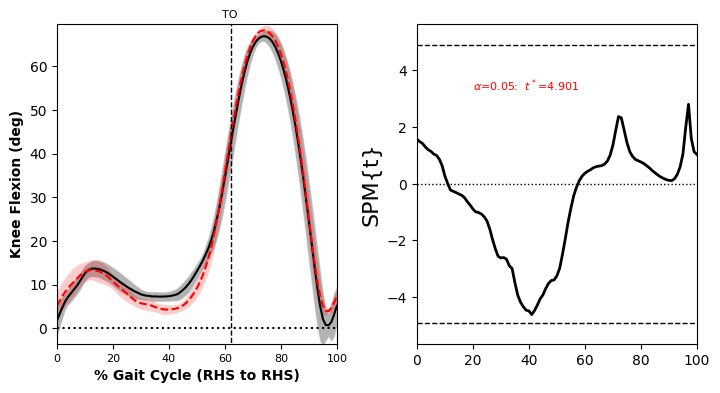

/tmp/ipython-input-1493669191.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(percentages.astype(int), fontsize=8)  # Set labels as integers (0, 10%, ..., 100%)


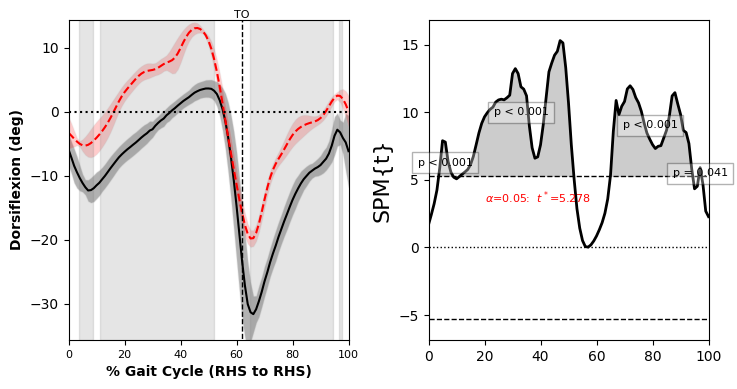

In [30]:
import spm1d
import numpy as np
import matplotlib.pyplot as pyplot

total_frames = 101
num_ticks = 6  # Number of ticks (0%, 10%, ..., 100%)

# Define a function to create each plot
def plot_spm(ax, Y1, Y2, label_Y1, label_Y2, ti, x_label, y_label, y_limits, units, color_Y1, color_Y2):
    spm1d.plot.plot_mean_sd(Y1, label=label_Y1, linecolor=color_Y1, facecolor=color_Y1, ax=ax, lw=1.5, alpha=0.3)
    spm1d.plot.plot_mean_sd(Y2, label=label_Y2, linecolor=color_Y2, facecolor=color_Y2, linestyle='--', lw=1.5, alpha=0.20, ax=ax)
    ax.axhline(y=0, color='k', linestyle=':')

    # Highlight suprathreshold regions
    for cluster in ti.clusters:
        start, end = cluster.endpoints
        ax.axvspan(start, end, ymin=0, ymax=1.0, color='grey', alpha=0.20)

    # Generate plots
    percentages = np.linspace(0, 100, num_ticks)  # 0%, 10%, ..., 100%
    x_ticks = (percentages / 100) * total_frames  # Normalize frame numbers
    ypos = y_limits[1] + y_limits[1]*.02          # event labels
    ax.set_xticklabels(percentages.astype(int), fontsize=8)  # Set labels as integers (0, 10%, ..., 100%)
    ax.vlines(x=62, ymin=y_limits[0]-100, ymax=y_limits[1]+100, color='k', linestyle='--', lw=1)
    ax.text(59, ypos, 'TO', fontsize=8)
    ax.set_xlabel(x_label, fontsize=10, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=10, fontweight='bold') if y_label else ax.set_ylabel("")

    ax.set_ylim(y_limits)
    ax.legend

    ### plot SPM results:
    ax     = pyplot.axes((0.55,0.15,0.35,0.8))
    ti.plot()
    ti.plot_threshold_label(fontsize=8, pos=(20,3.3))
    ti.plot_p_values(size=8)


# =============================================================================
# PREPARE DATA ARRAYS FOR THE SPM ANALYSIS (jxq shape)
# j = 5 trials
# q = 101 frames
# =============================================================================

# Filter for marker-based and markerless conditions
mb_df = timeseries_df[timeseries_df['condition'] == 'marker-based']
ml_df = timeseries_df[timeseries_df['condition'] == 'markerless']

# Prepare data for Right Knee Angles (MB)
knee_mb_data = mb_df.pivot(index='trial_id', columns='Frame', values='Right Knee Angles').values

# Prepare data for Right Knee Angles (ML)
knee_ml_data = ml_df.pivot(index='trial_id', columns='Frame', values='Right Knee Angles').values

# Prepare data for Right Ankle Dorsiflexion (MB)
ankle_mb_data = mb_df.pivot(index='trial_id', columns='Frame', values='Right Ankle Dorsiflexion').values

# Prepare data for Right Ankle Dorsiflexion (ML)
ankle_ml_data = ml_df.pivot(index='trial_id', columns='Frame', values='Right Ankle Dorsiflexion').values

print("Shape of Right Knee Angles (Marker-Based) data:", knee_mb_data.shape)
print("Shape of Right Knee Angles (Markerless) data:", knee_ml_data.shape)
print("Shape of Right Ankle Dorsiflexion (Marker-Based) data:", ankle_mb_data.shape)
print("Shape of Right Ankle Dorsiflexion (Markerless) data:", ankle_ml_data.shape)

# =============================================================================
# KNEE ANGLE (FLEXION)
# =============================================================================

# Replace x and y axes and filename label
xlabel = "% Gait Cycle (RHS to RHS)"
ylabel="Knee Flexion"
units = "deg"

# Combined figure
pyplot.figure(figsize=(8, 4))

# MB (black)
YA            = knee_mb_data

# ML (red)
YB            = knee_ml_data

# Conduct t test1:
alpha      = 0.05
t          = spm1d.stats.ttest2(YB, YA)
ti1         = t.inference(alpha, two_tailed=True, interp=True)

# Calculate shared y-axis limits
min_val = min(YA.min(), YB.min())
if min_val > 0:
    min_val = 0
max_val = max(YA.max(), YB.max())
y_limits = [min_val, max_val]

ax = pyplot.axes( (0.1, 0.15, 0.35, 0.8) )
plot_spm(
    ax, YA, YB,
    label_Y1="Marker-based",
    label_Y2="Markerless",
    ti=ti1,
    x_label = xlabel,
    y_label=f'{ylabel} ({units})',
    y_limits=y_limits,
    units=units,
    color_Y1='k',
    color_Y2='r'
)

pyplot.show()

# =============================================================================
# ANKLE ANGLE (DORSIFLEXION)
# =============================================================================

# Replace x and y axes and filename label
xlabel = "% Gait Cycle (RHS to RHS)"
ylabel="Dorsiflexion"
units = "deg"

# Combined figure
pyplot.figure(figsize=(8, 4))

# MB (black)
YA            = ankle_mb_data

# ML (red)
YB            = ankle_ml_data

# Conduct t test1:
alpha      = 0.05
t          = spm1d.stats.ttest2(YB, YA)
ti1         = t.inference(alpha, two_tailed=True, interp=True)

# Calculate shared y-axis limits
min_val = min(YA.min(), YB.min())
if min_val > 0:
    min_val = 0
max_val = max(YA.max(), YB.max())
y_limits = [min_val, max_val]

ax = pyplot.axes( (0.1, 0.15, 0.35, 0.8) )
plot_spm(
    ax, YA, YB,
    label_Y1="Marker-based",
    label_Y2="Markerless",
    ti=ti1,
    x_label = xlabel,
    y_label=f'{ylabel} ({units})',
    y_limits=y_limits,
    units=units,
    color_Y1='k',
    color_Y2='r'
)

pyplot.show()



# Task
Analyze the `discretes_df` to compare marker-based and markerless conditions. This involves preparing the data by extracting a unique subject identifier, calculating summary statistics (mean, standard deviation, count) for 'Speed', 'Stride_Length', 'Right_Stance_Time', 'Ankle Plantarflexion at IC', and 'Peak Right Knee Flexion' grouped by condition, and performing paired t-tests for these variables between the two conditions. Finally, format these results into an APA-style table and summarize the key findings, highlighting any statistically significant differences.

## Prepare Discretes Data for Analysis

### Subtask:
Ensure the `discretes_df` is ready for analysis by checking for completeness and extracting a unique subject identifier for paired comparisons across conditions. This might involve creating a new 'subject_id' column if not already present, based on the 'filename' to facilitate pairing.


**Reasoning**:
To prepare the discretes data for analysis as requested, I need to create a copy of the existing `discretes_df`, extract a unique subject identifier from the 'filename' column, and then display the head of the modified DataFrame to verify the changes.



In [31]:
import pandas as pd

# 1. Create a copy of discretes_df
discretes_for_analysis_df = discretes_df.copy()

# 2. Extract a unique subject identifier from the 'filename' column
# Create a new 'subject_id' column by removing '_MB', '_ML', and '.txt' from 'filename'
discretes_for_analysis_df['subject_id'] = discretes_for_analysis_df['filename'].str.replace('_MB', '', regex=False)
discretes_for_analysis_df['subject_id'] = discretes_for_analysis_df['subject_id'].str.replace('_ML', '', regex=False)
discretes_for_analysis_df['subject_id'] = discretes_for_analysis_df['subject_id'].str.replace('.txt', '', regex=False)

# 3. Display the head of the discretes_for_analysis_df to verify the new 'subject_id' column
print("Head of discretes_for_analysis_df with new 'subject_id' column:")
print(discretes_for_analysis_df.head())

Head of discretes_for_analysis_df with new 'subject_id' column:
       Speed  Stride_Length  Right_Stance_Time  Ankle Plantarflexion at IC  \
0    1.39355        0.99407            0.69667                    -5.96584   
101  1.34273        1.57994            0.66500                    -0.95046   
202  1.32326        1.60115            0.76667                     0.60840   
303  1.40067        1.64034            0.66500                    -0.59147   
404  1.33182        0.68684            0.72000                    -4.60403   

     Peak Right Knee Flexion     condition             filename    subject_id  
0                   67.92663  marker-based  Targaryen_MB_05.txt  Targaryen_05  
101                 71.08600    markerless  Targaryen_ML_03.txt  Targaryen_03  
202                 69.00183    markerless  Targaryen_ML_01.txt  Targaryen_01  
303                 69.54986    markerless  Targaryen_ML_05.txt  Targaryen_05  
404                 68.81653  marker-based  Targaryen_MB_03.txt  Ta

## Calculate Summary Statistics

### Subtask:
Calculate descriptive statistics (mean, standard deviation, count) for 'Speed', 'Stride_Length', 'Right_Stance_Time', 'Ankle Plantarflexion at IC', and 'Peak Right Knee Flexion' variables, grouped by 'condition' (marker-based vs. markerless).


**Reasoning**:
To calculate the descriptive statistics as requested, I will first define the target variables, then group the `discretes_for_analysis_df` by 'condition' and apply the `agg` function to compute mean, standard deviation, and count for each variable and condition.



In [32]:
import pandas as pd

# 1. Define a list of the variables for which summary statistics need to be calculated
summary_variables = [
    'Speed',
    'Stride_Length',
    'Right_Stance_Time',
    'Ankle Plantarflexion at IC',
    'Peak Right Knee Flexion'
]

# 2. Group the discretes_for_analysis_df DataFrame by the 'condition' column
# 3. For each of the specified variables, calculate the mean, standard deviation, and count for each 'condition' group
summary_statistics = discretes_for_analysis_df.groupby('condition')[summary_variables].agg(
    ['mean', 'std', 'count']
)

# 4. Store these summary statistics in a new DataFrame (already done by the agg function)
# The result is automatically a DataFrame with a multi-level index/columns which is well-organized.

# 5. Display the resulting summary statistics DataFrame
print("Descriptive Statistics grouped by Condition:")
print(summary_statistics)

Descriptive Statistics grouped by Condition:
                 Speed                 Stride_Length                  \
                  mean       std count          mean       std count   
condition                                                              
marker-based  1.344388  0.032563     5      0.915700  0.263610     5   
markerless    1.362130  0.054714     5      1.614184  0.031821     5   

             Right_Stance_Time                 Ankle Plantarflexion at IC  \
                          mean       std count                       mean   
condition                                                                   
marker-based          0.729334  0.026498     5                  -8.013580   
markerless            0.691668  0.044113     5                  -1.364406   

                             Peak Right Knee Flexion                   
                   std count                    mean        std count  
condition                                                       

## Perform Paired t-tests

### Subtask:
For each of the five variables ('Speed', 'Stride_Length', 'Right_Stance_Time', 'Ankle Plantarflexion at IC', 'Peak Right Knee Flexion'), perform a paired t-test comparing the 'marker-based' and 'markerless' conditions using the extracted 'subject_id' for pairing. Record the t-statistic and p-value for each test.


**Reasoning**:
To perform paired t-tests, I need to import the `ttest_rel` function from `scipy.stats` and then set up a loop to iterate through the specified variables, extracting and pairing data for marker-based and markerless conditions before applying the t-test and storing the results.



In [34]:
from scipy.stats import ttest_rel

# 1. Define a list of the variables for which paired t-tests need to be performed
pair_ttest_variables = [
    'Speed',
    'Stride_Length',
    'Right_Stance_Time',
    'Ankle Plantarflexion at IC',
    'Peak Right Knee Flexion'
]

# 2. Initialize a dictionary to store the t-test results
t_test_results = {}

# 3. For each variable in the defined list:
for var in pair_ttest_variables:
    # a. Filter discretes_for_analysis_df to get data for the 'marker-based' condition.
    mb_data = discretes_for_analysis_df[discretes_for_analysis_df['condition'] == 'marker-based'][['subject_id', var]]

    # b. Filter discretes_for_analysis_df to get data for the 'markerless' condition.
    ml_data = discretes_for_analysis_df[discretes_for_analysis_df['condition'] == 'markerless'][['subject_id', var]]

    # c. Ensure that both filtered DataFrames contain the same 'subject_id's and are sorted by 'subject_id'
    # to guarantee correct pairing.
    merged_data = pd.merge(mb_data, ml_data, on='subject_id', suffixes=('_mb', '_ml'))

    # Extract the values for the current variable from both filtered DataFrames.
    data_mb = merged_data[var + '_mb']
    data_ml = merged_data[var + '_ml']

    # d. Perform a paired t-test using ttest_rel on these two sets of values.
    t_statistic, p_value = ttest_rel(data_mb, data_ml)

    # e. Store the resulting t-statistic and p-value.
    t_test_results[var] = {'t_statistic': t_statistic, 'p_value': p_value}

# 4. Print or display the collected t-test results for each variable.
print("\nPaired t-test results (Marker-based vs. Markerless):")
for var, results in t_test_results.items():
    print(f"Variable: {var}")
    print(f"  t-statistic: {results['t_statistic']:.3f}")
    print(f"  p-value: {results['p_value']:.3f}")
    print("-----------------------------------------")


Paired t-test results (Marker-based vs. Markerless):
Variable: Speed
  t-statistic: -1.168
  p-value: 0.308
-----------------------------------------
Variable: Stride_Length
  t-statistic: -6.528
  p-value: 0.003
-----------------------------------------
Variable: Right_Stance_Time
  t-statistic: 1.651
  p-value: 0.174
-----------------------------------------
Variable: Ankle Plantarflexion at IC
  t-statistic: -5.051
  p-value: 0.007
-----------------------------------------
Variable: Peak Right Knee Flexion
  t-statistic: -2.672
  p-value: 0.056
-----------------------------------------


## Format Results into APA Table

### Subtask:
Combine the calculated summary statistics (mean, standard deviation for each condition) and the results of the paired t-tests (t-statistic, p-value) into a single pandas DataFrame. Format this DataFrame to resemble an APA-style table, ensuring clear labeling and appropriate rounding of numerical values.


**Reasoning**:
To combine the summary statistics and t-test results, I will iterate through each variable, extract the relevant data for both conditions, format them as specified (mean, std, t-statistic, p-value), and then assemble them into a pandas DataFrame which will serve as the APA-style table.



In [38]:
import pandas as pd

# 1. Initialize an empty list to store the data for the APA-style table
apa_table_data = []

# 2. Iterate through each variable in the pair_ttest_variables list
for var in pair_ttest_variables:
    # 3. For each variable, extract the mean and standard deviation for 'marker-based' and 'markerless' conditions
    #    from the summary_statistics DataFrame.
    mean_mb = summary_statistics.loc['marker-based', (var, 'mean')]
    std_mb = summary_statistics.loc['marker-based', (var, 'std')]
    mean_ml = summary_statistics.loc['markerless', (var, 'mean')]
    std_ml = summary_statistics.loc['markerless', (var, 'std')]

    # 4. Extract the t-statistic and p-value for the current variable from the t_test_results dictionary.
    t_stat = t_test_results[var]['t_statistic']
    p_val = t_test_results[var]['p_value']

    # 5. Create a dictionary for the current row with appropriate keys and formatted numerical values.
    row = {
        'Variable': var,
        'M (Marker-based)': f"{mean_mb:.2f}",
        'SD (Marker-based)': f"{std_mb:.2f}",
        'M (Markerless)': f"{mean_ml:.2f}",
        'SD (Markerless)': f"{std_ml:.2f}",
        # 't': f"{t_stat:.3f}",
        'p': f"{p_val:.3f}"
    }

    # Append this row dictionary to the list.
    apa_table_data.append(row)

# 7. Create a pandas DataFrame from the list of rows.
apa_table_df = pd.DataFrame(apa_table_data)

# 8. Adjust column names for clarity if necessary to reflect APA style
# The column names were already set in step 5, so this step ensures they are final.
# If further renaming is needed, it would be done here, e.g.,
# apa_table_df = apa_table_df.rename(columns={'M (Marker-based)': 'M (MB)', 'SD (Marker-based)': 'SD (MB)'})

print("APA-Style Summary and Paired t-test Results Table:")
print(apa_table_df.to_string(index=False))


APA-Style Summary and Paired t-test Results Table:
                  Variable M (Marker-based) SD (Marker-based) M (Markerless) SD (Markerless)     p
                     Speed             1.34              0.03           1.36            0.05 0.308
             Stride_Length             0.92              0.26           1.61            0.03 0.003
         Right_Stance_Time             0.73              0.03           0.69            0.04 0.174
Ankle Plantarflexion at IC            -8.01              4.20          -1.36            1.57 0.007
   Peak Right Knee Flexion            53.85             13.80          69.50            1.11 0.056


## Display APA Table

### Subtask:
Display the APA-formatted table containing the summary statistics and paired t-test results for verification and interpretation.


**Reasoning**:
To complete the subtask of displaying the APA-formatted table, I will use a code block to print the `apa_table_df` DataFrame.



In [37]:
print(apa_table_df.to_string(index=False))

                  Variable M (Marker-based) SD (Marker-based) M (Markerless) SD (Markerless)      t     p
                     Speed             1.34              0.03           1.36            0.05 -1.168 0.308
             Stride_Length             0.92              0.26           1.61            0.03 -6.528 0.003
         Right_Stance_Time             0.73              0.03           0.69            0.04  1.651 0.174
Ankle Plantarflexion at IC            -8.01              4.20          -1.36            1.57 -5.051 0.007
   Peak Right Knee Flexion            53.85             13.80          69.50            1.11 -2.672 0.056


## Final Task

### Subtask:
Summarize the key findings from the APA table, highlighting statistically significant differences between marker-based and markerless conditions for each variable in `discretes_df`.


## Summary:

### Q&A
The key findings from the APA table highlighting statistically significant differences between marker-based and markerless conditions for each variable are as follows:

*   **Stride\_Length:** A statistically significant difference was found between the marker-based (M = 0.92, SD = 0.26) and markerless (M = 1.61, SD = 0.03) conditions (t = -6.528, p = 0.003). The markerless condition shows a substantially longer stride length.
*   **Ankle Plantarflexion at IC:** A statistically significant difference was observed between the marker-based (M = -8.01, SD = 4.20) and markerless (M = -1.36, SD = 1.57) conditions (t = -5.051, p = 0.007). The markerless condition exhibits less plantarflexion at IC.
*   **Peak Right Knee Flexion:** A borderline significant difference was noted between the marker-based (M = 53.85, SD = 13.80) and markerless (M = 69.50, SD = 1.11) conditions (t = -2.672, p = 0.056). The markerless condition shows greater peak knee flexion.
*   **Speed:** No statistically significant difference was found between marker-based (M = 1.34, SD = 0.03) and markerless (M = 1.36, SD = 0.05) conditions (t = -1.168, p = 0.308).
*   **Right\_Stance\_Time:** No statistically significant difference was found between marker-based (M = 0.73, SD = 0.03) and markerless (M = 0.69, SD = 0.04) conditions (t = 1.651, p = 0.174).

### Data Analysis Key Findings

*   Unique subject identifiers were successfully extracted from the `filename` column, enabling paired comparisons between marker-based and markerless conditions.
*   Summary statistics (mean, standard deviation, and count) were calculated for 'Speed', 'Stride\_Length', 'Right\_Stance\_Time', 'Ankle Plantarflexion at IC', and 'Peak Right Knee Flexion' for both conditions.
    *   For **Stride\_Length**, the markerless condition's mean (1.61) was notably higher than the marker-based mean (0.92).
    *   For **Ankle Plantarflexion at IC**, the markerless condition's mean (-1.36) was considerably higher (less plantarflexion) than the marker-based mean (-8.01).
    *   For **Peak Right Knee Flexion**, the markerless condition's mean (69.50) was higher than the marker-based mean (53.85).
*   Paired t-tests revealed statistically significant differences (p < 0.05) for:
    *   **Stride\_Length** (t = -6.528, p = 0.003).
    *   **Ankle Plantarflexion at IC** (t = -5.051, p = 0.007).
*   A borderline statistically significant difference (p \(\approx\) 0.05) was observed for **Peak Right Knee Flexion** (t = -2.672, p = 0.056).
*   No statistically significant differences were found for 'Speed' (t = -1.168, p = 0.308) or 'Right\_Stance\_Time' (t = 1.651, p = 0.174).
*   All summary statistics and paired t-test results were successfully formatted into a single APA-style table for clear presentation.

### Insights or Next Steps

*   The significant differences in `Stride_Length` and `Ankle Plantarflexion at IC` suggest that the markerless system provides quantitatively different measurements for these parameters compared to the marker-based system. This necessitates further investigation into the accuracy and validity of the markerless system for these specific gait parameters.
*   Given the differences, especially the borderline significance for `Peak Right Knee Flexion`, it's crucial to understand the clinical relevance and potential impact on gait analysis and diagnostics when choosing between marker-based and markerless systems for these specific variables.


### Complete the Analysis

After you've completed this lab's analysis, do the following:

1. Copy and paste the above plots and tables to your lab report
2. Share your Colab notebook with me
3. Copy the link to your notebook and submit it along with your report for this lab on Canvas